In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib


In [ ]:

data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Price'] = data.target

In [ ]:
print(df.head())  
print(df.info())  
print(df.describe())  


   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  Price  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup   

In [ ]:
print(df.isnull().sum())  


MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Price         0
dtype: int64


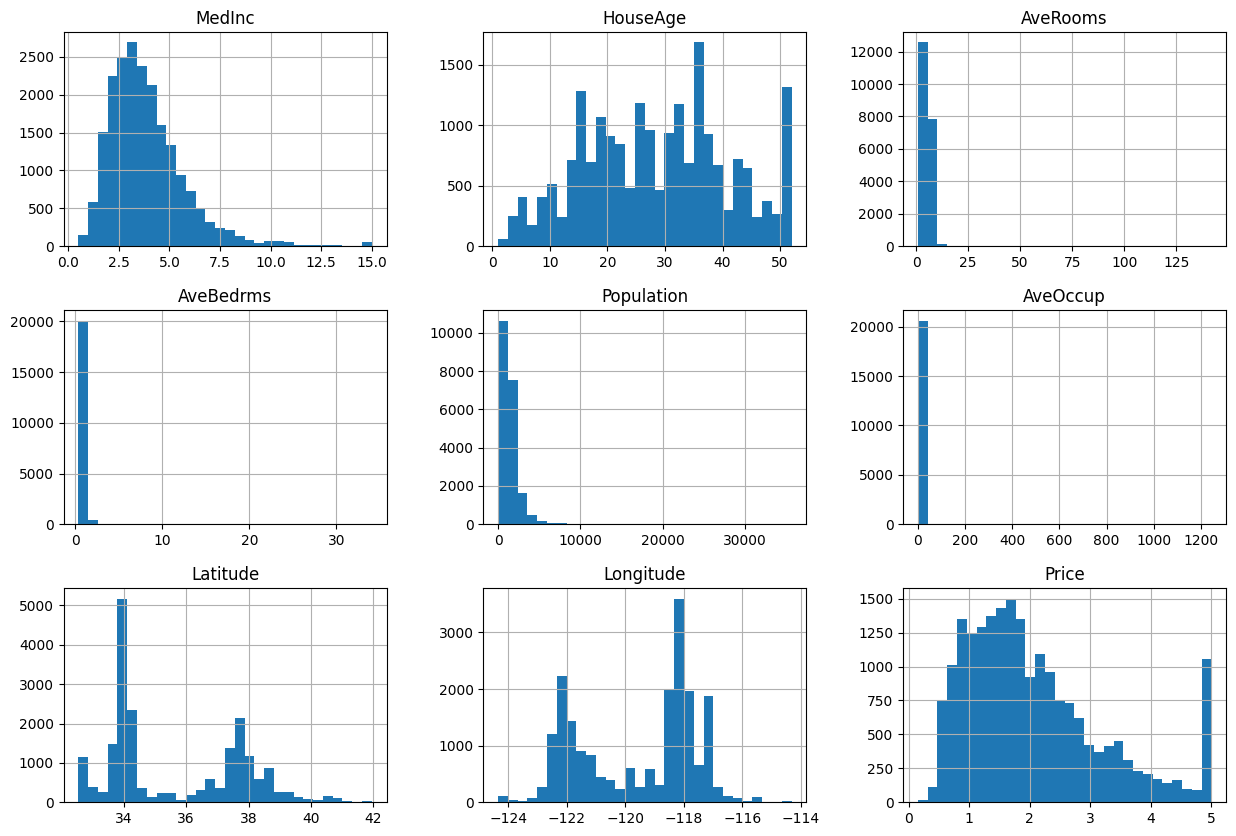

In [ ]:

df.hist(bins=30, figsize=(15, 10))
plt.show()

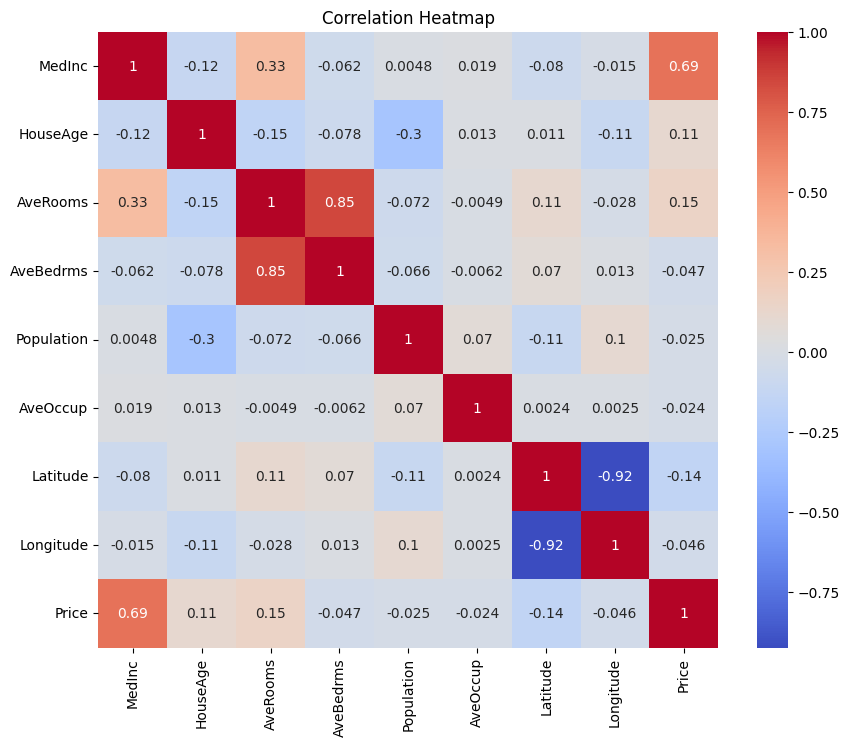

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

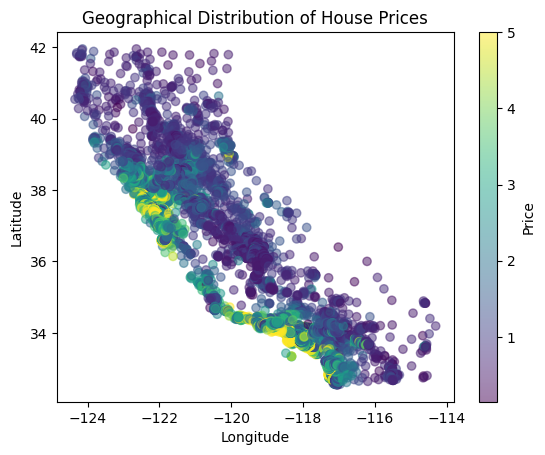

In [ ]:
plt.scatter(df['Longitude'], df['Latitude'], c=df['Price'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of House Prices')
plt.show()

In [ ]:
df['DistanceFromCoast'] = np.sqrt((df['Latitude'] - 34) ** 2 + (df['Longitude'] + 118) ** 2)

df['RoomsPerBedroom'] = df['AveRooms'] / df['AveBedrms']

In [20]:
import numpy as np

Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['Price'] < (Q1 - 1.5 * IQR)) | (df['Price'] > (Q3 + 1.5 * IQR))]
print(f"Number of outliers detected: {len(outliers)}")


Number of outliers detected: 1071


In [21]:
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Price'] >= Q1 - 1.5 * IQR) & (df['Price'] <= Q3 + 1.5 * IQR)]

In [ ]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:


rf = RandomForestRegressor(random_state=1)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
} 
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='r2')
grid_search_rf.fit(X_train, y_train)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best R2 Score for Random Forest:", grid_search_rf.best_score_)


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best R2 Score for Random Forest: 0.7682226232290731


In [32]:

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)


In [33]:

mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - MSE:", mse_rf, "MAE:", mae_rf, "R2:", r2_rf)


Random Forest - MSE: 0.18769953197138026 MAE: 0.29313921483563277 R2: 0.7952723418165468


In [34]:

xgb = XGBRegressor(random_state=1)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=5, scoring='r2')
grid_search_xgb.fit(X_train, y_train)

print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best R2 Score for XGBoost:", grid_search_xgb.best_score_)



Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best R2 Score for XGBoost: 0.811171737001404


In [36]:

best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost - MSE:", mse_xgb, "MAE:", mae_xgb, "R2:", r2_xgb)

XGBoost - MSE: 0.15276560480437723 MAE: 0.2620323359632078 R2: 0.8333754794479307


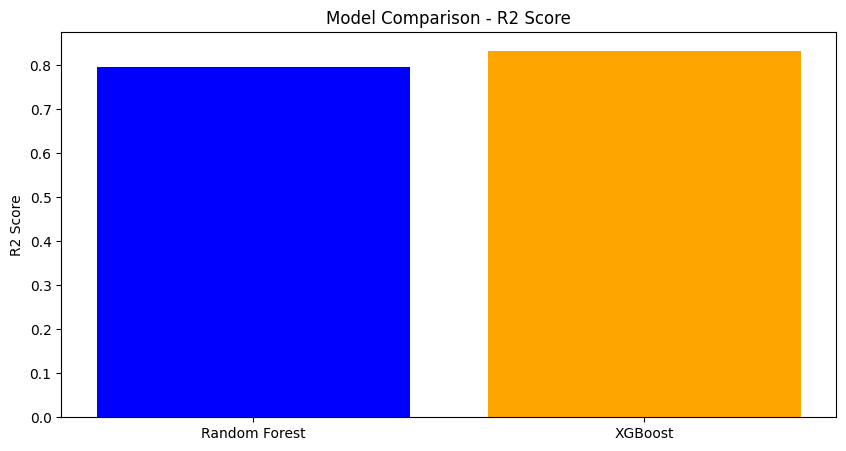

In [ ]:

models = ['Random Forest', 'XGBoost']
mse_scores = [mse_rf, mse_xgb]
mae_scores = [mae_rf, mae_xgb]
r2_scores = [r2_rf, r2_xgb]

plt.figure(figsize=(10, 5))
plt.bar(models, r2_scores, color=['blue', 'orange'])
plt.title('Model Comparison - R2 Score')
plt.ylabel('R2 Score')
plt.show()


In [31]:

if r2_rf > r2_xgb:
    best_model = best_rf
    print("Random Forest is the best model.")
else:
    best_model = best_xgb
    print("XGBoost is the best model.")


XGBoost is the best model.


In [ ]:

joblib.dump(best_model, 'best_model.joblib')
joblib.dump(scaler, 'scaler.joblib')


['scaler.joblib']

In [30]:

loaded_model = joblib.load('best_model.joblib')
loaded_scaler = joblib.load('scaler.joblib')


In [50]:

sample_data = X_test[0].reshape(1, -1)
scaled_sample_data = loaded_scaler.transform(sample_data)
predicted_price = loaded_model.predict(scaled_sample_data)
print("Predicted Price:", predicted_price)

Predicted Price: [1.2958368]


C:\Users\samal\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [51]:
price_usd = predicted_price[0] * 100000
exchange_rate = 83
price_inr = price_usd * exchange_rate

In [52]:

print(f"Predicted House Price (USD): ${price_usd:,.2f}")
print(f"Predicted House Price (INR): ₹{price_inr:,.2f}")

Predicted House Price (USD): $129,583.68
Predicted House Price (INR): ₹10,755,445.00
